1. Import Libraries
Start by importing the necessary libraries for df manipulation, visualization, and machine learning

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=174; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=174; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=174; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=251; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=251; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=288; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=288; total 

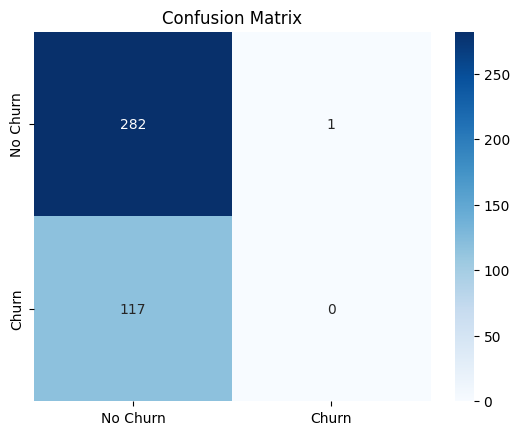

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 2000

# Create complex numerical features
age = np.random.randint(18, 70, size=n_samples)
income = np.random.normal(60000, 15000, size=n_samples).astype(int)
credit_score = np.random.normal(700, 50, size=n_samples).astype(int)
transaction_amount = np.random.normal(1000, 200, size=n_samples).astype(int)

# Create complex categorical features
gender = np.random.choice(['Male', 'Female'], size=n_samples)
education = np.random.choice(['High School', 'Bachelors', 'Masters', 'PhD'], size=n_samples)
region = np.random.choice(['North', 'South', 'East', 'West'], size=n_samples)
employment_status = np.random.choice(['Employed', 'Unemployed', 'Self-Employed'], size=n_samples)

# Create a binary target variable (Customer Churn or Purchase)
churn = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])  # 30% churn rate

# Create DataFrame
df = pd.DataFrame({
    'Age': age,
    'Income': income,
    'Credit_Score': credit_score,
    'Transaction_Amount': transaction_amount,
    'Gender': gender,
    'Education': education,
    'Region': region,
    'Employment_Status': employment_status,
    'Churn': churn
})

# Introduce some missing values
df.loc[df.sample(frac=0.1).index, 'Income'] = np.nan
df.loc[df.sample(frac=0.1).index, 'Transaction_Amount'] = np.nan
df.loc[df.sample(frac=0.05).index, 'Region'] = np.nan
df.loc[df.sample(frac=0.05).index, 'Education'] = np.nan

# Add some outliers to the 'Income' and 'Transaction_Amount' columns
df.loc[df.sample(frac=0.01).index, 'Income'] = df['Income'].max() + 10000
df.loc[df.sample(frac=0.01).index, 'Transaction_Amount'] = df['Transaction_Amount'].max() + 500

# Function to detect and handle outliers using IQR (Interquartile Range)
def handle_outliers(df, numerical_columns):
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)  # Cap the values to the outlier range
    return df

# Handle outliers for numerical columns
df = handle_outliers(df, numerical_columns=['Income', 'Transaction_Amount'])

# Handling missing values manually

# 1. For numerical columns, use SimpleImputer to replace missing values with the mean
numerical_columns = ['Income', 'Transaction_Amount', 'Credit_Score']
imputer_num = SimpleImputer(strategy='mean')
df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])

# 2. For categorical columns, use SimpleImputer to replace missing values with the mode (most frequent)
categorical_columns = ['Region', 'Education']
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])

# One-hot encoding categorical variables
df = pd.get_dummies(df, drop_first=True)

# Define features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
from scipy.stats import randint

# Hyperparameter space for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 301),  # Randomly pick from 100 to 300 trees
    'max_depth': [None, 10, 20, 30],  # Max depth options
    'min_samples_split': randint(2, 11),  # Randomly pick values for min samples split (2 to 10)
    'min_samples_leaf': randint(1, 5),  # Randomly pick values for min samples leaf (1 to 4)
    'max_features': ['sqrt', 'log2', None],  # Valid values for max_features in Random Forest
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# Perform grid search with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_classifier, 
    param_distributions=param_dist, 
    n_iter=10,  # Try 10 different combinations
    cv=3,  # 3-fold cross-validation to speed up the search
    n_jobs=-1,  # Use all cores for parallel processing
    random_state=42, 
    verbose=2
)

random_search.fit(X_train_scaled, y_train)

# Best hyperparameters from RandomizedSearchCV
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model
best_rf_classifier = random_search.best_estimator_

# Make predictions with the tuned model
y_pred = best_rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.show()


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=187; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=288; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=288; total time=   1.6s[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=288; total time=   1.5s

[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=187; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=3, min_samples_split=9, n_estimators=216; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=3, min_samples_split=9, n_estimators=216; tota

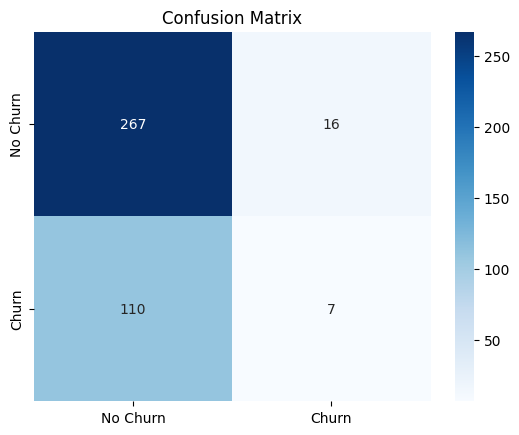

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 2000

# Create complex numerical features
age = np.random.randint(18, 70, size=n_samples)
income = np.random.normal(60000, 15000, size=n_samples).astype(int)
credit_score = np.random.normal(700, 50, size=n_samples).astype(int)
transaction_amount = np.random.normal(1000, 200, size=n_samples).astype(int)

# Create complex categorical features
gender = np.random.choice(['Male', 'Female'], size=n_samples)
education = np.random.choice(['High School', 'Bachelors', 'Masters', 'PhD'], size=n_samples)
region = np.random.choice(['North', 'South', 'East', 'West'], size=n_samples)
employment_status = np.random.choice(['Employed', 'Unemployed', 'Self-Employed'], size=n_samples)

# Create a binary target variable (Customer Churn or Purchase)
churn = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])  # 30% churn rate

# Create DataFrame
df = pd.DataFrame({
    'Age': age,
    'Income': income,
    'Credit_Score': credit_score,
    'Transaction_Amount': transaction_amount,
    'Gender': gender,
    'Education': education,
    'Region': region,
    'Employment_Status': employment_status,
    'Churn': churn
})

# Introduce some missing values
df.loc[df.sample(frac=0.1).index, 'Income'] = np.nan
df.loc[df.sample(frac=0.1).index, 'Transaction_Amount'] = np.nan
df.loc[df.sample(frac=0.05).index, 'Region'] = np.nan
df.loc[df.sample(frac=0.05).index, 'Education'] = np.nan

# Add some outliers to the 'Income' and 'Transaction_Amount' columns
df.loc[df.sample(frac=0.01).index, 'Income'] = df['Income'].max() + 10000
df.loc[df.sample(frac=0.01).index, 'Transaction_Amount'] = df['Transaction_Amount'].max() + 500

# Function to detect and handle outliers using IQR (Interquartile Range)
def handle_outliers(df, numerical_columns):
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)  # Cap the values to the outlier range
    return df

# Handle outliers for numerical columns
df = handle_outliers(df, numerical_columns=['Income', 'Transaction_Amount'])

# Handling missing values manually

# 1. For numerical columns, use SimpleImputer to replace missing values with the mean
numerical_columns = ['Income', 'Transaction_Amount', 'Credit_Score']
imputer_num = SimpleImputer(strategy='mean')
df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])

# 2. For categorical columns, use SimpleImputer to replace missing values with the mode (most frequent)
categorical_columns = ['Region', 'Education']
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])

# One-hot encoding categorical variables
df = pd.get_dummies(df, drop_first=True)

# Define features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RandomForestClassifier with class_weight='balanced' for handling class imbalance
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Expanded Hyperparameter space for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 301),  # Randomly pick from 100 to 300 trees
    'max_depth': [None, 10, 20, 30, 40],  # Max depth options
    'min_samples_split': randint(2, 11),  # Randomly pick values for min samples split (2 to 10)
    'min_samples_leaf': randint(1, 5),  # Randomly pick values for min samples leaf (1 to 4)
    'max_features': ['sqrt', 'log2', None],  # Valid values for max_features in Random Forest
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# Perform RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_classifier, 
    param_distributions=param_dist, 
    n_iter=10,  # Try 10 different combinations
    cv=3,  # 3-fold cross-validation to speed up the search
    n_jobs=-1,  # Use all cores for parallel processing
    random_state=42, 
    verbose=2
)

random_search.fit(X_train_scaled, y_train)

# Best hyperparameters from RandomizedSearchCV
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model
best_rf_classifier = random_search.best_estimator_

# Make predictions with the tuned model
y_pred = best_rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_rf_classifier.predict_proba(X_test_scaled)[:, 1])

# Print evaluation results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print(f"ROC AUC: {roc_auc:.2f}")

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.show()
